In [42]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import os
from matplotlib.cm import get_cmap
from scipy.stats import truncnorm, qmc
from tqdm import tqdm
import scipy.stats as stats
from scipy.stats import wasserstein_distance, ks_2samp
import seaborn as sns
from itertools import product
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import hamming_loss
from sklearn.model_selection import train_test_split
import scipy.stats as stats
from scipy.stats import uniform
from matplotlib import colormaps
import matplotlib.colors as mcolors
import ili
from ili.dataloaders import NumpyLoader
from ili.inference import InferenceRunner
from ili.validation.metrics import PosteriorCoverage, PlotSinglePosterior
from torch.distributions import Distribution, Uniform, HalfNormal
from torch.distributions.utils import broadcast_all
import math
from ili.utils.distributions_pt import CustomIndependent
import itertools
import emcee

import symbolic_pofk.syren_new as syren_new
import symbolic_pofk.linear as linear
import pickle

# Device configuration
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)
sns.set(style="whitegrid", context="paper", font_scale=1.5)

Device: cpu


In [2]:
# Load posterior ensembles for neural posterior estimators
with open('/home/x-ctirapongpra/scratch/tailed-uniform-sbi/sci-2-dim-models/uniform_power/ensemble.pkl', 'rb') as f:
    posterior_ensemble_old = pickle.load(f)
with open('/home/x-ctirapongpra/scratch/tailed-uniform-sbi/sci-2-dim-models/tailed_power/ensemble.pkl', 'rb') as f:
    posterior_ensemble = pickle.load(f)

In [3]:
# Global constants
L, N = 1000, 64
kf = 2*np.pi/L
knyq = np.pi*N/L
kedges = np.arange(0, knyq, kf)
kcenters = (kedges[:-1] + kedges[1:])/2
a = 1.0

# Original parameter ranges
param_1_range = (0.27, 0.37)   # Om
param_2_range = (0.63, 0.71)    # h
param_ranges = [param_1_range, param_2_range]

param_1_width = param_1_range[1] - param_1_range[0]
param_2_width = param_2_range[1] - param_2_range[0]

# Prior parameters
param_1_mean = (param_1_range[0] + param_1_range[1]) / 2  # Om mean
param_2_mean = (param_2_range[0] + param_2_range[1]) / 2  # h mean
param_1_std = 0.1 * (param_1_range[1] - param_1_range[0])   # Om std
param_2_std = 0.1 * (param_2_range[1] - param_2_range[0])   # h std

# simulator function
def simulator(theta):
   """Simulator: theta -> P(k)"""
   Om, h = theta
   # Also fixed (for now)
   As = 2.105  # 10^9 A_s
   Ob = 0.02242 / h ** 2
   ns = 0.9665
   w0 = -1.0  
   wa = 0.0
   mnu = 0.0
   pk_syren_theory = syren_new.pnl_new_emulated(
         kcenters, As, Om, Ob, h, ns, mnu, w0, wa, a=a
      )

   var_single = np.abs(pk_syren_theory)**2
   Nk = L**3 * kcenters**2 * kf / (2*np.pi**2)
   var_mode = var_single * 2 / Nk
   std_mode = np.sqrt(var_mode)

   pk_w_noise = pk_syren_theory + std_mode*np.random.randn(*pk_syren_theory.shape)
   return pk_w_noise

In [4]:
class TailedNormal(Distribution):
    arg_constraints = {
        'a': torch.distributions.constraints.real,
        'b': torch.distributions.constraints.dependent,
        'sigma': torch.distributions.constraints.positive,
    }
    support = torch.distributions.constraints.real
    has_rsample = False

    def __init__(self, a, b, sigma, validate_args=None):
        self.a, self.b, self.sigma = broadcast_all(a, b, sigma)
        if torch.any(self.a >= self.b):
            raise ValueError("`a` must be less than `b`.")
        
        self.Z = math.sqrt(2 * math.pi) * self.sigma + (self.b - self.a)
        self.A = math.sqrt(2 * math.pi) * self.sigma / self.Z
        self.B = (self.b - self.a) / self.Z

        self.halfnormal = HalfNormal(self.sigma)

        super().__init__(batch_shape=self.a.size(), validate_args=validate_args)

    def log_prob(self, x):
        x, a, b, sigma = broadcast_all(x, self.a, self.b, self.sigma)

        logA = torch.log(self.A.to(dtype=x.dtype, device=x.device))
        logB = torch.log(self.B.to(dtype=x.dtype, device=x.device))
        log_uniform = logB - torch.log(b - a)

        # left: x <= a => z = a - x
        z_left = torch.abs(a - x)
        log_halfnorm_left = self.halfnormal.log_prob(z_left) + logA - math.log(2.0)

        # right: x >= b => z = x - b
        z_right = torch.abs(x - b)
        log_halfnorm_right = self.halfnormal.log_prob(z_right) + logA - math.log(2.0)

        return torch.where(x <= a, log_halfnorm_left,
               torch.where(x >= b, log_halfnorm_right,
               log_uniform))

    def cdf(self, x):
        x, a, b, sigma = broadcast_all(x, self.a, self.b, self.sigma)
        sqrt2 = math.sqrt(2.0)

        def Phi(z):  # Standard Normal CDF
            return 0.5 * (1 + torch.erf(z / sqrt2))

        left_cdf = self.A * Phi((x - a) / sigma)
        center_cdf = 0.5 * self.A + self.B * (x - a) / (b - a)
        right_cdf = self.B + self.A * Phi((x - b) / sigma)

        return torch.where(x <= a, left_cdf,
               torch.where(x >= b, right_cdf,
               center_cdf))
    
    def icdf(self, u):
        # Helper function for the Inverse Standard Normal CDF
        def inv_Phi(p):
            # Clamping p to avoid NaNs from erfinv at the boundaries 0 and 1
            p_clamped = torch.clamp(p, 1e-9, 1.0 - 1e-9)
            return math.sqrt(2.0) * torch.erfinv(2.0 * p_clamped - 1.0)

        # Thresholds dividing the distribution regions
        thresh_left = 0.5 * self.A
        thresh_right = 1.0 - 0.5 * self.A

        u_left_norm = u / self.A
        left_tail = self.a + self.sigma * inv_Phi(u_left_norm)

        u_right_norm = (u - self.B) / self.A
        right_tail = self.b + self.sigma * inv_Phi(u_right_norm)

        u_middle_norm = (u - thresh_left) / self.B
        middle = self.a + u_middle_norm * (self.b - self.a)

        return torch.where(u < thresh_left, left_tail,
                           torch.where(u > thresh_right, right_tail, middle))
        

    def sample(self, sample_shape=torch.Size()):
        u = torch.rand(sample_shape + self.a.shape, device=self.a.device)
        thresh_left = 0.5 * self.A
        thresh_right = 1.0 - 0.5 * self.A

        left_tail = self.a - self.halfnormal.sample(sample_shape)
        right_tail = self.b + self.halfnormal.sample(sample_shape)

        x_middle = self.a + (u - thresh_left) * (self.b - self.a) / self.B

        return torch.where(u < thresh_left, left_tail,
               torch.where(u > thresh_right, right_tail,
               x_middle))
    
    def sample_lhs(self, n_samples):
        """Sample using Latin Hypercube Sampling"""
        # Generate LHS samples in [0,1]^d
        sampler = qmc.LatinHypercube(d=len(self.a.flatten()), seed=42)
        u_samples = sampler.random(n_samples)
        u_tensor = torch.tensor(u_samples, dtype=torch.float32, device=self.a.device)
        
        # Transform using inverse CDF
        return self.icdf(u_tensor)

    def mean(self):
        return 0.5 * (self.a + self.b)

IndependentTailedNormal = type('IndependentTailedNormal', (CustomIndependent,), {'Distribution': TailedNormal})

In [5]:
def simulator(theta):
   """Simulator: theta -> P(k)"""
   Om, h = theta
   # Also fixed (for now)
   As = 2.105  # 10^9 A_s
   Ob = 0.02242 / h ** 2
   ns = 0.9665
   w0 = -1.0  
   wa = 0.0
   mnu = 0.0
   pk_syren_theory = syren_new.pnl_new_emulated(
         kcenters, As, Om, Ob, h, ns, mnu, w0, wa, a=a
      )

   var_single = np.abs(pk_syren_theory)**2
   Nk = L**3 * kcenters**2 * kf / (2*np.pi**2)
   var_mode = var_single * 2 / Nk
   std_mode = np.sqrt(var_mode)

   pk_w_noise = pk_syren_theory + std_mode*np.random.randn(*pk_syren_theory.shape)
   return pk_w_noise

In [6]:
class SBIEvaluator:
   def __init__(self, param_names=['θ₁', 'θ₂']):
       self.param_names = param_names
   
   def c2st(self, X1, X2):
       X = np.vstack([X1, X2])
       y = np.concatenate([np.zeros(len(X1)), np.ones(len(X2))])
       X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
       clf = LogisticRegression(max_iter=1000)
       y_pred = clf.fit(X_train, y_train).predict(X_test)
       return hamming_loss(y_test, y_pred)
   
   def tarp_score(self, samples, true_theta):
       """TARP calibration score - lower is better"""
       alpha_levels = np.linspace(0.05, 0.95, 19)
       empirical_coverage = []
       
       for alpha in alpha_levels:
           coverage = all(
               np.percentile(samples[:, j], 100*alpha/2) <= true_theta[j] <= 
               np.percentile(samples[:, j], 100*(1-alpha/2))
               for j in range(len(true_theta))
           )
           empirical_coverage.append(coverage)
       
       expected_coverage = 1 - alpha_levels
       return np.mean(np.abs(expected_coverage - empirical_coverage))
   
   def compare(self, samples_dict, true_theta):
       """Compare multiple methods"""
       results = {}
       methods = list(samples_dict.keys())
       
       for method, samples in samples_dict.items():
           results[method] = {
               'tarp': self.tarp_score(samples, true_theta),
               'mean': np.mean(samples, axis=0),
               'std': np.std(samples, axis=0),
               'c2st_vs_others': {}
           }
       
       # C2ST comparisons
       for i, method1 in enumerate(methods):
           for method2 in methods[i+1:]:
               score = self.c2st(samples_dict[method1], samples_dict[method2])
               results[method1]['c2st_vs_others'][method2] = score
               results[method2]['c2st_vs_others'][method1] = score
       
       return results
   
   def print_results(self, results, true_theta):
       """Print concise comparison"""
       methods = list(results.keys())
       
       print("Method Comparison")
       print("-" * 50)
       
       for method in methods:
           stats = results[method]
           print(f"\n{method}:")
           print(f"  TARP: {stats['tarp']:.4f}")
           for i, param in enumerate(self.param_names):
               print(f"  {param}: Mean={stats['mean'][i]:.3f}, Std={stats['std'][i]:.3f}")
           
           if stats['c2st_vs_others']:
               c2st_str = ", ".join([f"{k}={v:.3f}" for k, v in stats['c2st_vs_others'].items()])
               print(f"  C2ST: {c2st_str}")

In [7]:
# Load test points from grid dataset
mcmc_folder = '/home/x-ctirapongpra/scratch/tailed-uniform-sbi/mcmc_samples/grid'
test_points_all = np.load(f'{mcmc_folder}/test_points.npy')
mcmc_samples_all = np.load(f'{mcmc_folder}/mcmc_samples.npy')
observations_all = np.load(f'{mcmc_folder}/observations.npy')

# Define 3 specific test points (40% away from edges)
# Test point 1: 40% from left edge in param_1, 40% from bottom edge in param_2
test_point_1 = np.array([
    param_1_range[0] + 0.4 * (param_1_range[1] - param_1_range[0]),  # 0.27 + 0.04 = 0.31
    param_2_range[0] + 0.4 * (param_2_range[1] - param_2_range[0])   # 0.63 + 0.032 = 0.662
])

# Test point 2: Center point
test_point_2 = np.array([
    (param_1_range[0] + param_1_range[1]) / 2,  # 0.32
    (param_2_range[0] + param_2_range[1]) / 2   # 0.67
])

# Test point 3: 40% from right edge in param_1, 40% from top edge in param_2
test_point_3 = np.array([
    param_1_range[1] - 0.4 * (param_1_range[1] - param_1_range[0]),  # 0.37 - 0.04 = 0.33
    param_2_range[1] - 0.4 * (param_2_range[1] - param_2_range[0])   # 0.71 - 0.032 = 0.678
])

specific_test_points = np.array([test_point_1, test_point_2, test_point_3])

print("Specific test points to find:")
for i, pt in enumerate(specific_test_points):
    print(f"  Test point {i+1}: param_1={pt[0]:.3f}, param_2={pt[1]:.3f}")

# Find closest matching points in test_points_all
n_test_points = 3
selected_indices = []

for i, target_point in enumerate(specific_test_points):
    # Compute Euclidean distance to all test points
    distances = np.linalg.norm(test_points_all - target_point, axis=1)
    closest_idx = np.argmin(distances)
    selected_indices.append(closest_idx)
    
    print(f"\nTest point {i+1} target: {target_point}")
    print(f"  Closest match at index {closest_idx}: {test_points_all[closest_idx]}")
    print(f"  Distance: {distances[closest_idx]:.6f}")

selected_indices = np.array(selected_indices)

# Extract corresponding MCMC samples using indices
mcmc_samples_list = []
test_points_selected = []

for idx in selected_indices:
    mcmc_samples = mcmc_samples_all[idx]  # Shape: (n_samples, 2)
    mcmc_samples_list.append(mcmc_samples)
    test_points_selected.append(test_points_all[idx])
    print(f"\nLoaded MCMC samples for index {idx}: shape {mcmc_samples.shape}")
    print(f"  Mean: {np.mean(mcmc_samples, axis=0)}")
    print(f"  Std:  {np.std(mcmc_samples, axis=0)}")

test_points_selected = np.array(test_points_selected)

Specific test points to find:
  Test point 1: param_1=0.310, param_2=0.662
  Test point 2: param_1=0.320, param_2=0.670
  Test point 3: param_1=0.330, param_2=0.678

Test point 1 target: [0.31  0.662]
  Closest match at index 168: [0.31210526 0.66368421]
  Distance: 0.002696

Test point 2 target: [0.32 0.67]
  Closest match at index 189: [0.31736842 0.66789474]
  Distance: 0.003370

Test point 3 target: [0.33  0.678]
  Closest match at index 231: [0.32789474 0.67631579]
  Distance: 0.002696

Loaded MCMC samples for index 168: shape (8000, 2)
  Mean: [0.3088902  0.66693116]
  Std:  [0.00442264 0.00383534]

Loaded MCMC samples for index 189: shape (8000, 2)
  Mean: [0.31510241 0.66914244]
  Std:  [0.00476226 0.00394252]

Loaded MCMC samples for index 231: shape (8000, 2)
  Mean: [0.3255275  0.67838149]
  Std:  [0.00474087 0.00375606]


In [8]:
# Generate observations for each test point
observations_list = []

for i, theta_true in enumerate(test_points_selected):
    print(f"\nTest point {i+1}/{n_test_points}: {theta_true}")
    
    # Generate observation
    x_obs = simulator(theta_true)
    
    # Apply log10 transform (matching training data)
    x_obs_log = np.log10(x_obs)
    
    # Handle NaN values
    mask = np.isnan(x_obs_log)
    if np.any(mask):
        assert np.any(~mask), f"NaN for test point {i} (theta={theta_true})"
        x_obs_log[mask] = np.nanmean(x_obs_log)
    
    observations_list.append(x_obs_log)
    print(f"  Observation shape: {x_obs_log.shape}")


Test point 1/3: [0.31210526 0.66368421]
  Observation shape: (31,)

Test point 2/3: [0.31736842 0.66789474]
  Observation shape: (31,)

Test point 3/3: [0.32789474 0.67631579]
  Observation shape: (31,)


/tmp/ipykernel_2575318/3660026810.py:11: RuntimeWarning: invalid value encountered in log10
  x_obs_log = np.log10(x_obs)


In [9]:
# Sample from both neural ensembles
n_posterior_samples = 8000

uniform_npe_samples_list = []
tailed_npe_samples_list = []

print(f"Sampling {n_posterior_samples} posterior samples from both ensembles:")

for i, x_obs in enumerate(observations_list):
    # Sample from Uniform NPE
    print("  Sampling from Uniform NPE...")
    samples_uniform = posterior_ensemble_old.sample((n_posterior_samples,), x_obs).cpu().numpy()
    uniform_npe_samples_list.append(samples_uniform)
    
    # Sample from TailedNormal NPE
    print("  Sampling from TailedNormal NPE...")
    samples_tailed = posterior_ensemble.sample((n_posterior_samples,), x_obs).cpu().numpy()
    tailed_npe_samples_list.append(samples_tailed)

INFO:root:Sampling models with [1814, 1640, 1589, 1487, 1472] samples each.


Sampling 8000 posterior samples from both ensembles:
  Sampling from Uniform NPE...


Drawing 1814 posterior samples:   0%|          | 0/1814 [00:00<?, ?it/s]

Drawing 1814 posterior samples: 2000it [00:01, 1689.78it/s]                         
Drawing 1640 posterior samples: 2000it [00:00, 80269.15it/s]            
Drawing 1589 posterior samples: 2000it [00:00, 11020.91it/s]                         
Drawing 1487 posterior samples: 2000it [00:00, 370980.36it/s]           
Drawing 1472 posterior samples: 2000it [00:00, 372462.84it/s]           
INFO:root:Sampling models with [1818, 1655, 1577, 1557, 1395] samples each.


  Sampling from TailedNormal NPE...


Drawing 1818 posterior samples: 2000it [00:00, 86219.17it/s]            
Drawing 1655 posterior samples: 2000it [00:00, 98737.13it/s]            
Drawing 1577 posterior samples: 2000it [00:00, 71696.89it/s]            
Drawing 1557 posterior samples: 2000it [00:00, 89455.58it/s]            
Drawing 1395 posterior samples: 2000it [00:00, 88151.74it/s]            
INFO:root:Sampling models with [1814, 1640, 1589, 1487, 1472] samples each.


  Sampling from Uniform NPE...


Drawing 1814 posterior samples: 2000it [00:00, 357266.10it/s]           
Drawing 1640 posterior samples: 2000it [00:00, 188342.98it/s]           
Drawing 1589 posterior samples: 2000it [00:00, 366650.99it/s]           
Drawing 1487 posterior samples: 2000it [00:00, 367212.75it/s]           
Drawing 1472 posterior samples: 2000it [00:00, 353532.03it/s]           
INFO:root:Sampling models with [1818, 1655, 1577, 1557, 1395] samples each.


  Sampling from TailedNormal NPE...


Drawing 1818 posterior samples: 2000it [00:00, 26882.60it/s]            
Drawing 1655 posterior samples: 2000it [00:00, 104478.86it/s]           
Drawing 1577 posterior samples: 2000it [00:00, 77167.85it/s]            
Drawing 1557 posterior samples: 2000it [00:00, 89288.95it/s]            
Drawing 1395 posterior samples: 2000it [00:00, 92415.07it/s]            
INFO:root:Sampling models with [1814, 1640, 1589, 1487, 1472] samples each.


  Sampling from Uniform NPE...


Drawing 1814 posterior samples: 2000it [00:00, 364737.95it/s]           
Drawing 1640 posterior samples: 2000it [00:00, 198138.93it/s]           
Drawing 1589 posterior samples: 2000it [00:00, 365214.33it/s]           
Drawing 1487 posterior samples: 2000it [00:00, 375262.06it/s]           
Drawing 1472 posterior samples: 2000it [00:00, 383917.99it/s]           
INFO:root:Sampling models with [1818, 1655, 1577, 1557, 1395] samples each.


  Sampling from TailedNormal NPE...


Drawing 1818 posterior samples: 2000it [00:00, 90364.30it/s]            
Drawing 1655 posterior samples: 2000it [00:00, 105570.20it/s]           
Drawing 1577 posterior samples: 2000it [00:00, 45074.84it/s]            
Drawing 1557 posterior samples: 2000it [00:00, 87144.41it/s]            
Drawing 1395 posterior samples: 2000it [00:00, 26206.13it/s]            


In [10]:
# Evaluate all test points using the SBIEvaluator
evaluator = SBIEvaluator(param_names=['Om', 'h'])

all_results = []

for i in range(n_test_points):
    print(f"\n{'='*70}")
    print(f"TEST POINT {i+1}/{n_test_points}")
    print(f"{'='*70}")
    print(f"True parameters: {test_points_selected[i]}")
    print(f"Index: {selected_indices[i]}")
    
    # Prepare samples dictionary
    samples_dict = {
        'Reference': mcmc_samples_list[i],
        'Uniform': uniform_npe_samples_list[i],
        'TailedUniform': tailed_npe_samples_list[i]
    }
    
    # Evaluate
    results = evaluator.compare(samples_dict, test_points_selected[i])
    all_results.append(results)
    
    # Print results
    evaluator.print_results(results, test_points_selected[i])


TEST POINT 1/3
True parameters: [0.31210526 0.66368421]
Index: 168
Method Comparison
--------------------------------------------------

Reference:
  TARP: 0.2789
  Om: Mean=0.309, Std=0.004
  h: Mean=0.667, Std=0.004
  C2ST: Uniform=0.114, TailedUniform=0.079

Uniform:
  TARP: 0.4526
  Om: Mean=0.321, Std=0.006
  h: Mean=0.657, Std=0.005
  C2ST: Reference=0.114, TailedUniform=0.392

TailedUniform:
  TARP: 0.4526
  Om: Mean=0.324, Std=0.007
  h: Mean=0.655, Std=0.005
  C2ST: Reference=0.079, Uniform=0.392

TEST POINT 2/3
True parameters: [0.31736842 0.66789474]
Index: 189
Method Comparison
--------------------------------------------------

Reference:
  TARP: 0.2789
  Om: Mean=0.315, Std=0.005
  h: Mean=0.669, Std=0.004
  C2ST: Uniform=0.502, TailedUniform=0.481

Uniform:
  TARP: 0.2947
  Om: Mean=0.315, Std=0.006
  h: Mean=0.670, Std=0.005
  C2ST: Reference=0.502, TailedUniform=0.502

TailedUniform:
  TARP: 0.2947
  Om: Mean=0.315, Std=0.007
  h: Mean=0.670, Std=0.005
  C2ST: Referen


Creating corner plot for test point 1/3...
Saved corner plot for test point 1: sci-2-dim-figures/corner_testpoint_1.pdf


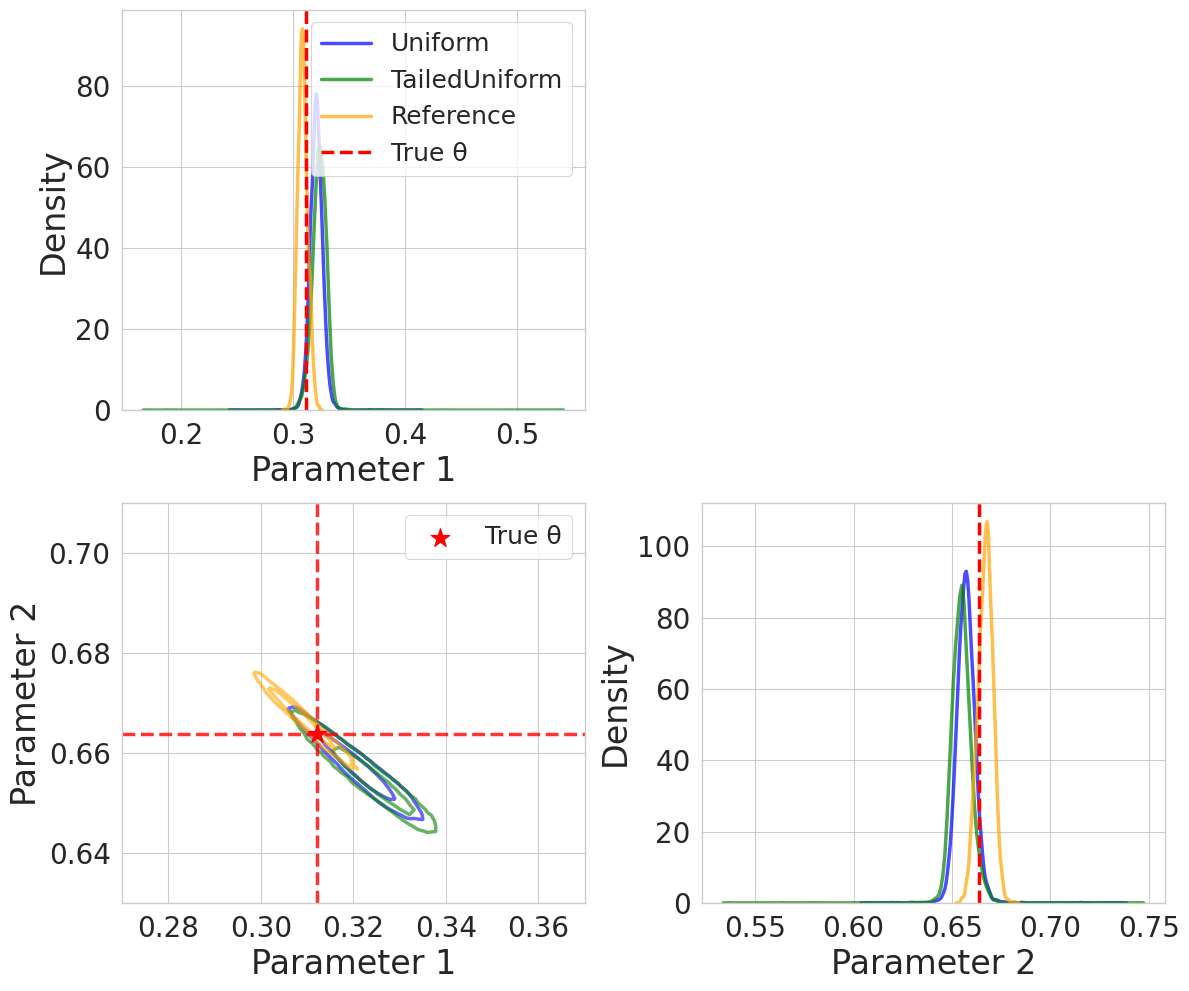


Creating corner plot for test point 2/3...
Saved corner plot for test point 2: sci-2-dim-figures/corner_testpoint_2.pdf


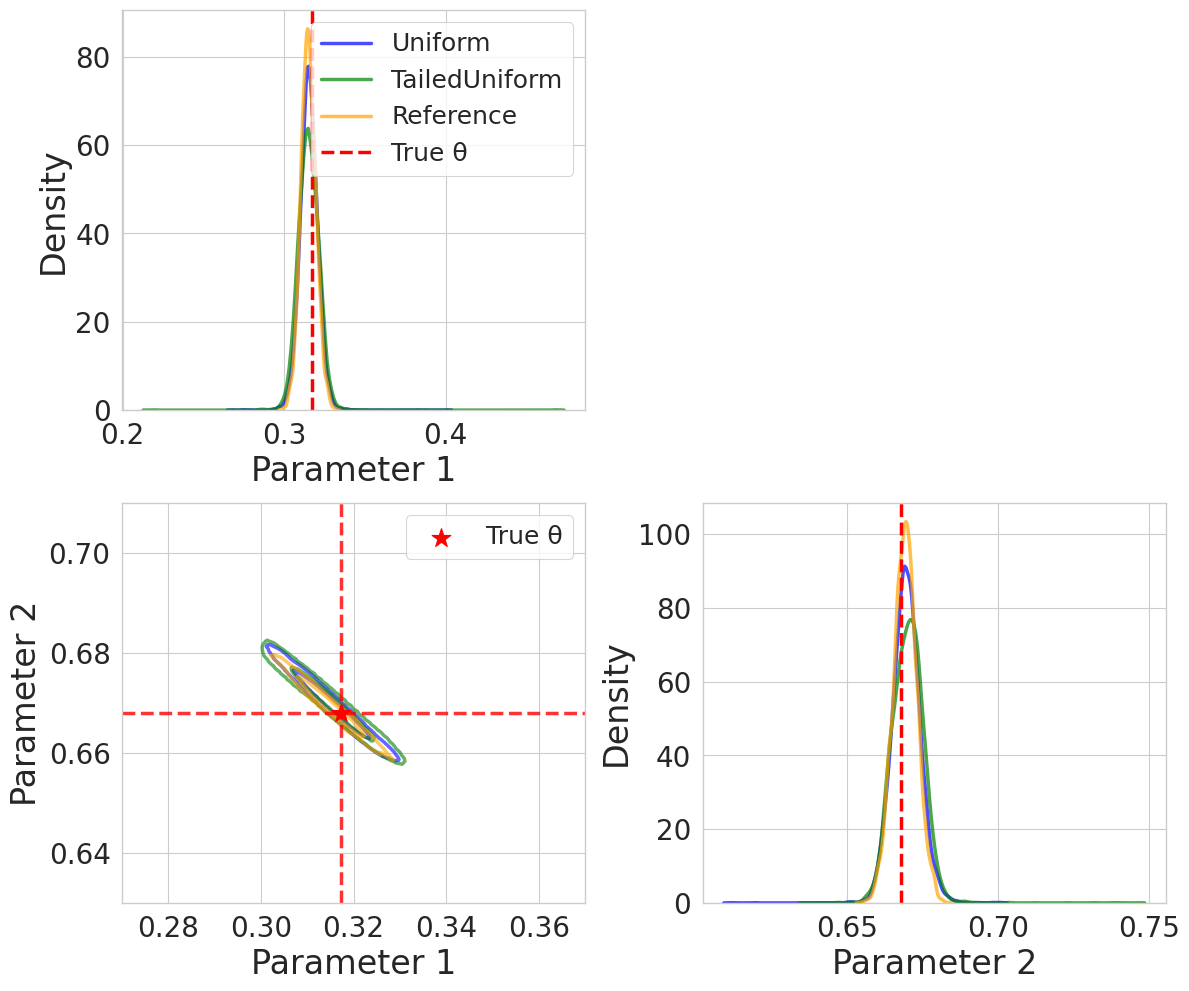


Creating corner plot for test point 3/3...
Saved corner plot for test point 3: sci-2-dim-figures/corner_testpoint_3.pdf


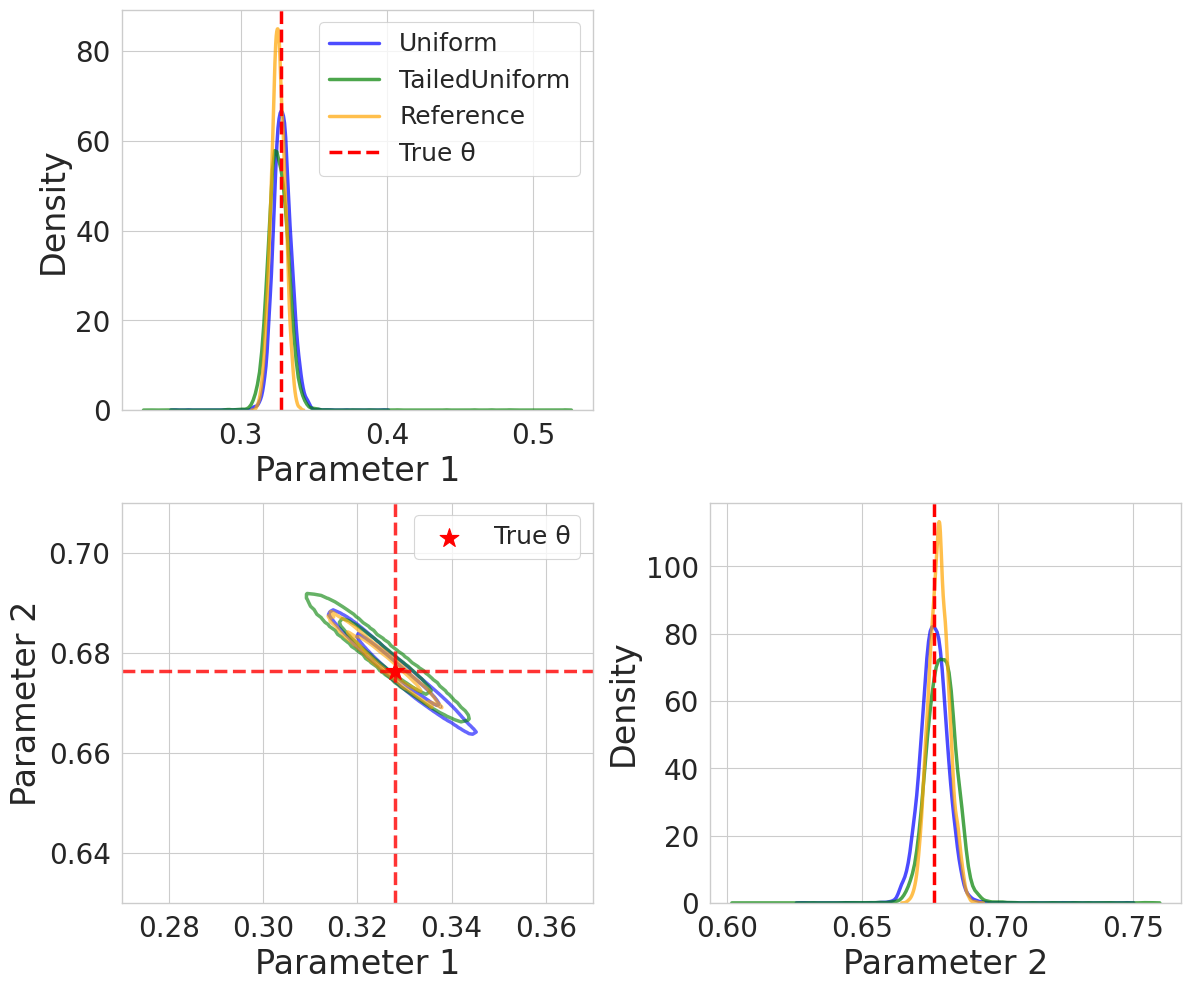

In [11]:
# Create corner plots for all test points
for test_idx in range(n_test_points):
    print(f"\nCreating corner plot for test point {test_idx+1}/{n_test_points}...")
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    methods = ['Uniform', 'TailedUniform', 'Reference']
    samples_list = [
        uniform_npe_samples_list[test_idx], 
        tailed_npe_samples_list[test_idx], 
        mcmc_samples_list[test_idx]
    ]
    colors = ['blue', 'green', 'orange']
    param_names = ['Parameter 1', 'Parameter 2']
    
    # Get true parameter for this test point
    theta_true = test_points_selected[test_idx]

    # Increase font sizes
    label_fontsize = 24
    tick_fontsize = 20
    legend_fontsize = 18

    # Plot marginal distributions (diagonal)
    for i in range(2):
        ax = axes[i, i]
        for method, samples, color in zip(methods, samples_list, colors):
            sns.kdeplot(data=samples[:, i], ax=ax, label=method, color=color, alpha=0.7, linewidth=2.5)
        
        # Add true parameter line
        ax.axvline(theta_true[i], color='red', linestyle='--', linewidth=2.5, label='True θ')
        ax.set_xlabel(param_names[i], fontsize=label_fontsize)
        ax.set_ylabel('Density', fontsize=label_fontsize)
        ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
        if i == 0:
            ax.legend(fontsize=legend_fontsize)

    # Plot joint distributions (off-diagonal) - only 68th and 95th percentiles
    ax = axes[1, 0]  # Bottom-left for joint distribution
    for method, samples, color in zip(methods, samples_list, colors):
        sns.kdeplot(x=samples[:, 0], y=samples[:, 1], ax=ax, color=color, alpha=0.6, 
                    levels=[0.05, 0.32], label=method, fill=False, linewidths=2.5)

    # Add true parameter point
    ax.scatter(theta_true[0], theta_true[1], color='red', s=200, 
               marker='*', label='True θ', zorder=10)

    # Add red lines to show true parameter values as boundaries
    ax.axvline(theta_true[0], color='red', linestyle='--', linewidth=2.5, alpha=0.8)
    ax.axhline(theta_true[1], color='red', linestyle='--', linewidth=2.5, alpha=0.8)

    ax.set_xlabel(param_names[0], fontsize=label_fontsize)
    ax.set_ylabel(param_names[1], fontsize=label_fontsize)
    ax.set_xlim(param_ranges[0])
    ax.set_ylim(param_ranges[1])
    ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
    ax.legend(fontsize=legend_fontsize)

    # Remove top-right subplot (not needed in corner plot)
    axes[0, 1].remove()

    plt.tight_layout()
    filename = f'sci-2-dim-figures/corner_testpoint_{test_idx+1}.pdf'
    plt.savefig(filename, bbox_inches='tight', dpi=300)
    print(f"Saved corner plot for test point {test_idx+1}: {filename}")
    plt.show()

Evaluate all test points from the rectangular grid against both neural ensemble models and MCMC ground truth.

In [63]:
class RectGridEvaluator:
    """Evaluator for rectangular grid of test points"""

    def __init__(self, param_ranges):
        self.param_ranges = param_ranges

    def c2st(self, X1, X2):
        """C2ST score - measures distributional similarity"""
        from sklearn.model_selection import train_test_split
        from sklearn.linear_model import LogisticRegression
        from sklearn.metrics import hamming_loss

        X = np.vstack([X1, X2])
        y = np.concatenate([np.zeros(len(X1)), np.ones(len(X2))])
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, random_state=42
        )
        clf = LogisticRegression(max_iter=1000)
        y_pred = clf.fit(X_train, y_train).predict(X_test)
        return hamming_loss(y_test, y_pred)

    def load_grid_data(self, mcmc_folder, n_points_per_dim=20):
        """
        Load Reference grid data from disk

        Returns:
            test_points: (n_points, 2) array of test points
            reference_samples: (n_points, n_samples, 2) array of Reference samples
            observations: (n_points, n_k_bins) array of observations
        """
        import glob

        # Try to load data
        try:
            test_points = np.load(f'{mcmc_folder}/test_points.npy')
            reference_samples = np.load(f'{mcmc_folder}/mcmc_samples.npy')
            observations = np.load(f'{mcmc_folder}/observations.npy')
            print(f"Loaded grid data:")
            return test_points, reference_samples, observations
        except:
            pass

        raise FileNotFoundError(f"No grid data found in {mcmc_folder}")

    def evaluate_npe_on_grid(self, posterior_dict, observations, n_samples=8000):
        """
        Sample from NPE posteriors for all grid observations

        Args:
            posterior_dict: Dictionary of {name: posterior_ensemble}
            observations: Array of observations (n_points, n_features)
            n_samples: Number of posterior samples per point

        Returns:
            results_dict: {method_name: samples_array} where samples_array
                         has shape (n_points, n_samples, 2)
        """
        results = {}

        for name, posterior in posterior_dict.items():
            print(f"\nSampling from {name}...")
            samples_list = []

            for i, x_obs in enumerate(tqdm(observations, desc=f"  {name}")):
                # Convert to log10 if needed
                if not np.all(x_obs < 10):  # Assume already log10 if all values < 10
                    x_obs_log = np.log10(x_obs)
                    mask = np.isnan(x_obs_log)
                    if np.any(mask):
                        x_obs_log[mask] = np.nanmean(x_obs_log)
                    x_obs = x_obs_log

                # Sample from posterior
                samples = posterior.sample((n_samples,), x_obs).cpu().numpy()
                samples_list.append(samples)

            results[name] = np.array(samples_list)
            print(f"  Shape: {results[name].shape}")

        return results

    def save_npe_samples(self, npe_results, save_folder):
        """
        Save NPE samples to disk

        Args:
            npe_results: Dictionary of NPE samples {name: (n_points, n_samples, 2)}
            save_folder: Path to save the samples
        """
        print("\nSaving NPE samples to disk...")
        for method_name, samples in npe_results.items():
            filename = f'{save_folder}/{method_name.lower()}_samples.npy'
            np.save(filename, samples)
            file_size_mb = samples.nbytes / 1e6
            print(f"  Saved {filename}")
            print(f"    Shape: {samples.shape}, Size: {file_size_mb:.2f} MB")

        print("\nAll NPE samples saved successfully!")

    def compute_radial_distance(self, test_points, normalize=True):
        """
        Compute radial distance of test points from parameter space center

        Args:
            test_points: (n_points, 2) array of test points
            normalize: If True, normalize by parameter ranges before computing distance

        Returns:
            distances: (n_points,) array of distances from center
            center: (2,) array of parameter space center
        """
        # Compute center of parameter space
        center = np.array([
            (self.param_ranges[0][0] + self.param_ranges[0][1]) / 2,
            (self.param_ranges[1][0] + self.param_ranges[1][1]) / 2
        ])

        if normalize:
            # Normalize by parameter ranges to give equal weight to both dimensions
            param_widths = np.array([
                self.param_ranges[0][1] - self.param_ranges[0][0],
                self.param_ranges[1][1] - self.param_ranges[1][0]
            ])
            normalized_points = (test_points - center) / param_widths
            distances = np.linalg.norm(normalized_points, axis=1)
        else:
            distances = np.linalg.norm(test_points - center, axis=1)

        return distances, center

    def compute_c2st_grid(self, reference_samples, npe_results, n_points_per_dim):
        """
        Compute C2ST scores across the grid

        Args:
            reference_samples: (n_points, n_reference_samples, 2) Reference samples
            npe_results: Dictionary of NPE samples {name: (n_points, n_samples, 2)}
            n_points_per_dim: Grid dimension

        Returns:
            c2st_grid: Dictionary of C2ST heatmaps
        """
        methods = list(npe_results.keys())
        c2st_grid = {}

        # Reference vs each NPE
        for method in methods:
            comparison_name = f"Reference_vs_{method}"
            c2st_values = []

            print(f"\nComputing C2ST for {comparison_name}...")
            for idx in tqdm(range(len(reference_samples))):
                c2st_val = self.c2st(reference_samples[idx], npe_results[method][idx])
                c2st_values.append(c2st_val)

            c2st_values = np.array(c2st_values)
            c2st_grid[comparison_name] = c2st_values.reshape(n_points_per_dim,
                                                             n_points_per_dim)

        # NPE vs NPE comparisons
        for i, m1 in enumerate(methods):
            for m2 in methods[i+1:]:
                comparison_name = f"{m1}_vs_{m2}"
                c2st_values = []

                print(f"\nComputing C2ST for {comparison_name}...")
                for idx in tqdm(range(len(reference_samples))):
                    c2st_val = self.c2st(npe_results[m1][idx], npe_results[m2][idx])
                    c2st_values.append(c2st_val)

                c2st_values = np.array(c2st_values)
                c2st_grid[comparison_name] = c2st_values.reshape(n_points_per_dim,
                                                                 n_points_per_dim)

        return c2st_grid

    def plot_c2st_heatmaps(self, c2st_grid, n_points_per_dim, save_path=None):
        """
        Plot C2ST scores as heatmaps

        Args:
            c2st_grid: Dictionary of C2ST arrays
            n_points_per_dim: Grid dimension
            save_path: Optional path to save figure
        """
        comparisons = list(c2st_grid.keys())
        n_comparisons = len(comparisons)

        fig, axes = plt.subplots(n_comparisons, 1,
                                figsize=(12, 8*n_comparisons))
        if n_comparisons == 1:
            axes = [axes]

        for i, comp in enumerate(comparisons):
            im = axes[i].imshow(c2st_grid[comp], cmap='RdYlBu_r',
                               vmin=0.2, vmax=0.5,
                               extent=[self.param_ranges[0][0],
                                      self.param_ranges[0][1],
                                      self.param_ranges[1][0],
                                      self.param_ranges[1][1]],
                               origin='lower', aspect='auto')

            # Add text annotations
            for j in range(n_points_per_dim):
                for k in range(n_points_per_dim):
                    value = c2st_grid[comp][j, k]
                    color = 'white' if value > 0.5 else 'black'

                    # Calculate pixel coordinates
                    x_extent = self.param_ranges[0][1] - self.param_ranges[0][0]
                    y_extent = self.param_ranges[1][1] - self.param_ranges[1][0]
                    x_pos = self.param_ranges[0][0] + (k + 0.5) * x_extent / n_points_per_dim
                    y_pos = self.param_ranges[1][0] + (j + 0.5) * y_extent / n_points_per_dim

                    axes[i].text(x_pos, y_pos, f'{value:.2f}',
                               ha='center', va='center',
                               color=color, fontsize=8)

            axes[i].set_title(comp.replace('_', ' '), fontsize=18)
            axes[i].set_xlabel('$\\Omega_m$', fontsize=14)
            axes[i].set_ylabel('$h$', fontsize=14)
            cbar = fig.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)
            cbar.set_label('C2ST Score', fontsize=14)
            cbar.ax.axhline(0.5, color='black', linestyle='--', linewidth=2)
            axes[i].grid(False)

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, bbox_inches='tight', dpi=150)
            print(f"\nSaved heatmap to: {save_path}")

        plt.show()

In [64]:
# Initialize evaluator
rect_evaluator = RectGridEvaluator(param_ranges=param_ranges)

# Evaluate NPE models on grid
posterior_dict_grid = {
    'Uniform_NPE': posterior_ensemble_old,
    'TailedUniform_NPE': posterior_ensemble
}

In [30]:
# Load grid MCMC data
mcmc_folder_grid = '/home/x-ctirapongpra/scratch/tailed-uniform-sbi/mcmc_samples/grid'
n_points_per_dim = 20

test_points_grid, mcmc_samples_grid, observations_grid = rect_evaluator.load_grid_data(
    mcmc_folder_grid, n_points_per_dim=n_points_per_dim
)

print(f"\nGrid: {n_points_per_dim} × {n_points_per_dim} = {len(test_points_grid)} test points")
print(f"\nFirst 5 test points:")
for i in range(min(5, len(test_points_grid))):
    print(f"  {i}: {test_points_grid[i]}")

Loaded grid data:

Grid: 20 × 20 = 400 test points

First 5 test points:
  0: [0.27 0.63]
  1: [0.27       0.63421053]
  2: [0.27       0.63842105]
  3: [0.27       0.64263158]
  4: [0.27       0.64684211]


In [ ]:
# Check if NPE samples already exist on disk

npe_sample_files = {
    'Uniform_NPE': f'{mcmc_folder_grid}/uniform_npe_samples.npy',
    'TailedUniform_NPE': f'{mcmc_folder_grid}/taileduniform_npe_samples.npy'
}

# Check if files exist
all_files_exist = all(os.path.exists(filepath) for filepath in npe_sample_files.values())

if all_files_exist:
    print("NPE samples already exist on disk. Loading from files...")
    npe_results_grid = {}
    for method_name, filepath in npe_sample_files.items():
        npe_results_grid[method_name] = np.load(filepath)
        print(f"  Loaded {method_name}: {npe_results_grid[method_name].shape}")
        file_size_mb = npe_results_grid[method_name].nbytes / 1e6
        print(f"    Size: {file_size_mb:.2f} MB")
    print("\nAll NPE samples loaded successfully from disk!")
else:
    print("NPE samples not found on disk. Generating new samples...")
    # Evaluate NPE models on grid
    posterior_dict_grid = {
        'Uniform_NPE': posterior_ensemble_old,
        'TailedUniform_NPE': posterior_ensemble
    }

    n_posterior_samples_grid = 8000

    npe_results_grid = rect_evaluator.evaluate_npe_on_grid(
        posterior_dict_grid,
        observations_grid,
        n_samples=n_posterior_samples_grid
    )

    print(f"\nNPE evaluation complete!")
    print(f"Results:")
    for method, samples in npe_results_grid.items():
        print(f"  {method}: {samples.shape}")
    
    # Save NPE grid samples to disk
    rect_evaluator.save_npe_samples(npe_results_grid, mcmc_folder_grid)


NPE samples already exist on disk. Loading from files...
  Loaded Uniform_NPE: (400, 8000, 2)
    Size: 25.60 MB
  Loaded TailedUniform_NPE: (400, 8000, 2)
    Size: 25.60 MB

All NPE samples loaded successfully from disk!


In [33]:
# Compute C2ST scores across the grid
c2st_grid_rect = rect_evaluator.compute_c2st_grid(
    mcmc_samples_grid,
    npe_results_grid,
    n_points_per_dim
)

print(f"\nC2ST grid computation complete!")
print(f"Comparisons computed:")
for comp_name, grid in c2st_grid_rect.items():
    print(f"  {comp_name}: shape {grid.shape}, mean={np.mean(grid):.3f}, std={np.std(grid):.3f}")



Computing C2ST for Reference_vs_Uniform_NPE...


100%|██████████| 400/400 [00:04<00:00, 82.92it/s] 



Computing C2ST for Reference_vs_TailedUniform_NPE...


100%|██████████| 400/400 [00:04<00:00, 94.60it/s] 



Computing C2ST for Uniform_NPE_vs_TailedUniform_NPE...


100%|██████████| 400/400 [00:04<00:00, 83.19it/s] 


C2ST grid computation complete!
Comparisons computed:
  Reference_vs_Uniform_NPE: shape (20, 20), mean=0.417, std=0.076
  Reference_vs_TailedUniform_NPE: shape (20, 20), mean=0.417, std=0.070
  Uniform_NPE_vs_TailedUniform_NPE: shape (20, 20), mean=0.412, std=0.060



Saved heatmap to: sci-2-dim-figures/grid_c2st_heatmaps.pdf


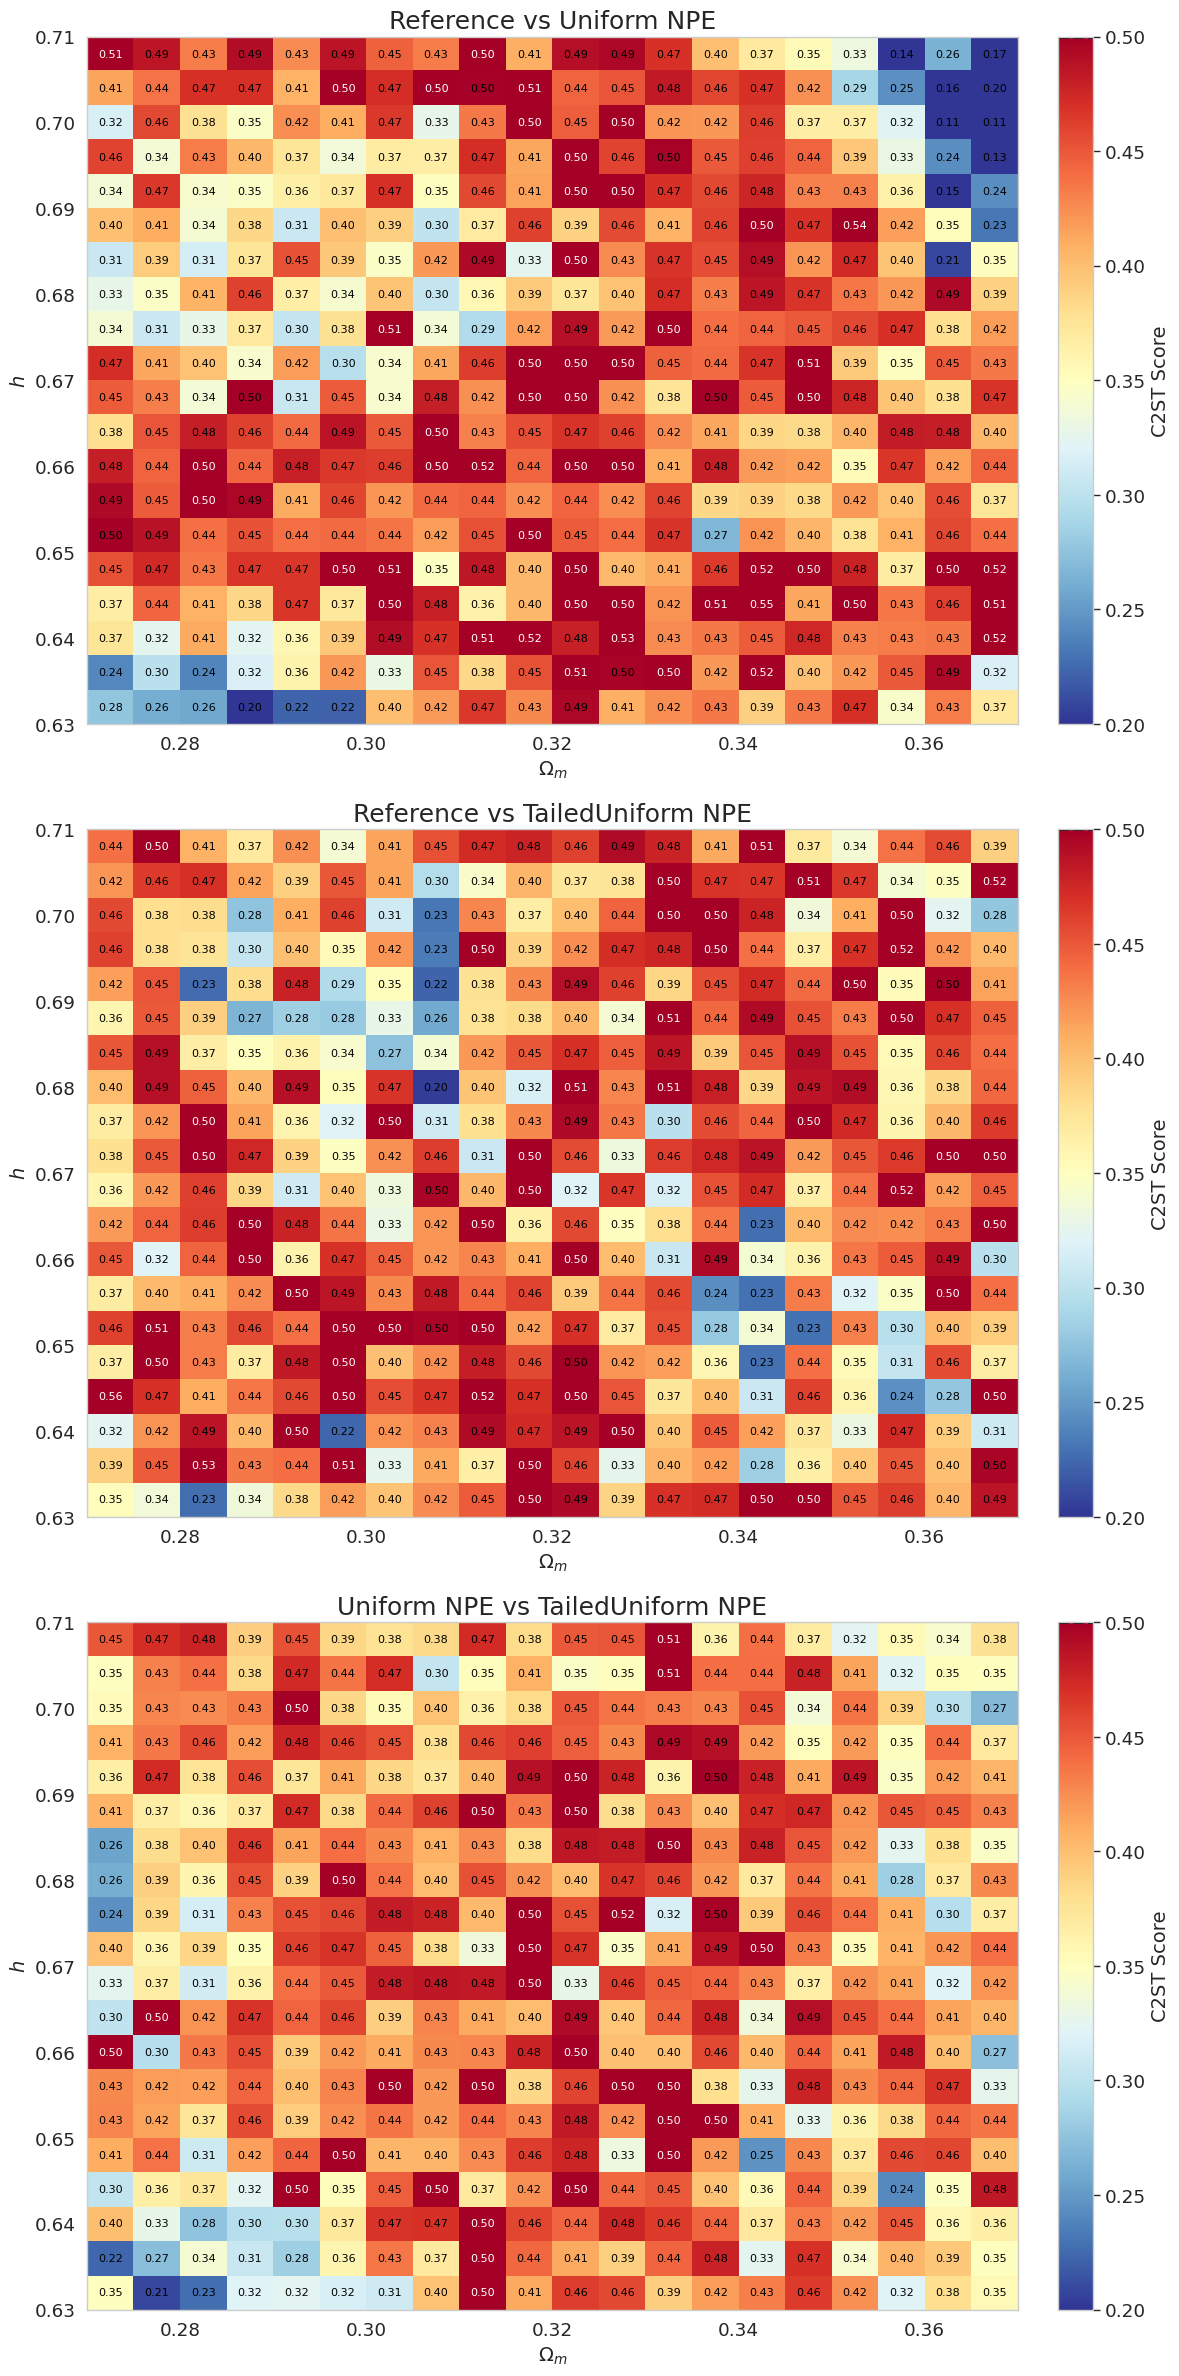

In [65]:
# Plot C2ST heatmaps for rectangular grid
save_path = 'sci-2-dim-figures/grid_c2st_heatmaps.pdf'

rect_evaluator.plot_c2st_heatmaps(
    c2st_grid_rect,
    n_points_per_dim,
    save_path=save_path
)



Saved difference heatmap to: sci-2-dim-figures/grid_c2st_difference_heatmap.pdf

C2ST Difference Statistics:
  Mean: -0.0006
  Std:  0.0930
  Min:  -0.2925 (Uniform best advantage)
  Max:  0.3463 (TailedUniform best advantage)
  Median: -0.0022

Number of points where:
  TailedUniform better (positive): 192 / 400
  Uniform better (negative):      204 / 400
  Equal:                          4 / 400


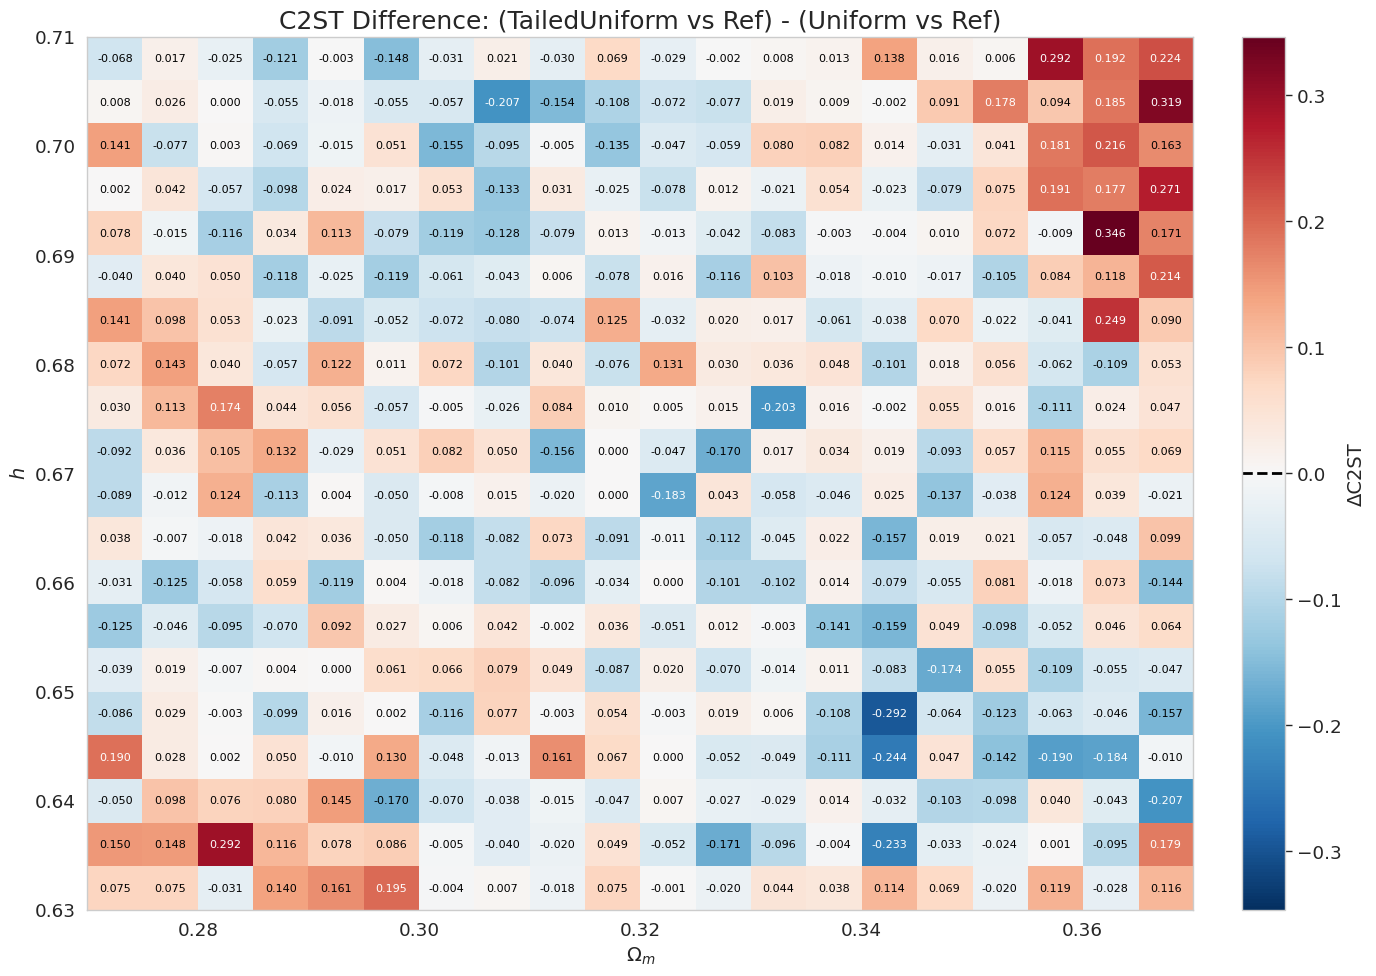

In [67]:
# Compute C2ST difference: TailedUniform vs Ref MINUS Uniform vs Ref
# Note: C2ST closer to 0.5 is better (means distributions are more similar)
# Positive values mean TailedUniform has higher C2ST (closer to 0.5) = better
# Negative values mean TailedUniform has lower C2ST (farther from 0.5) = worse
c2st_difference = c2st_grid_rect['Reference_vs_TailedUniform_NPE'] - c2st_grid_rect['Reference_vs_Uniform_NPE']

# Plot the difference heatmap
fig, ax = plt.subplots(1, 1, figsize=(14, 10))

# Use a diverging colormap centered at 0
# Positive (red) = TailedUniform is better, Negative (blue) = Uniform is better
vmax = np.max(np.abs(c2st_difference))
im = ax.imshow(c2st_difference, cmap='RdBu_r',
               vmin=-vmax, vmax=vmax,
               extent=[param_ranges[0][0], param_ranges[0][1],
                      param_ranges[1][0], param_ranges[1][1]],
               origin='lower', aspect='auto')

# Add text annotations
for j in range(n_points_per_dim):
    for k in range(n_points_per_dim):
        value = c2st_difference[j, k]
        
        # Choose text color for readability
        abs_normalized = np.abs(value) / vmax
        color = 'white' if abs_normalized > 0.5 else 'black'
        
        # Calculate pixel coordinates
        x_extent = param_ranges[0][1] - param_ranges[0][0]
        y_extent = param_ranges[1][1] - param_ranges[1][0]
        x_pos = param_ranges[0][0] + (k + 0.5) * x_extent / n_points_per_dim
        y_pos = param_ranges[1][0] + (j + 0.5) * y_extent / n_points_per_dim
        
        ax.text(x_pos, y_pos, f'{value:.3f}',
               ha='center', va='center',
               color=color, fontsize=8)

ax.set_title('C2ST Difference: (TailedUniform vs Ref) - (Uniform vs Ref)', 
             fontsize=18)
ax.set_xlabel('$\\Omega_m$', fontsize=14)
ax.set_ylabel('$h$', fontsize=14)
ax.grid(False)

cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('ΔC2ST', fontsize=14)
cbar.ax.axhline(0.0, color='black', linestyle='--', linewidth=2)

plt.tight_layout()

# Save the figure
save_path = 'sci-2-dim-figures/grid_c2st_difference_heatmap.pdf'
plt.savefig(save_path, bbox_inches='tight', dpi=150)
print(f"\nSaved difference heatmap to: {save_path}")

# Print summary statistics
print(f"\nC2ST Difference Statistics:")
print(f"  Mean: {np.mean(c2st_difference):.4f}")
print(f"  Std:  {np.std(c2st_difference):.4f}")
print(f"  Min:  {np.min(c2st_difference):.4f} (Uniform best advantage)")
print(f"  Max:  {np.max(c2st_difference):.4f} (TailedUniform best advantage)")
print(f"  Median: {np.median(c2st_difference):.4f}")
print(f"\nNumber of points where:")
print(f"  TailedUniform better (positive): {np.sum(c2st_difference > 0)} / {c2st_difference.size}")
print(f"  Uniform better (negative):      {np.sum(c2st_difference < 0)} / {c2st_difference.size}")
print(f"  Equal:                          {np.sum(c2st_difference == 0)} / {c2st_difference.size}")

plt.show()

In [56]:
# Compute directional distances for degeneracy analysis

def compute_directional_c2st(reference_samples, npe_results, test_points, n_bins=10):
    """
    Compute C2ST scores along two directions:
    - d1 = Om + h (degeneracy direction)
    - d2 = Om - h (perpendicular direction)
    
    Args:
        reference_samples: (n_points, n_reference_samples, 2) Reference samples
        npe_results: Dictionary of NPE samples {name: (n_points, n_samples, 2)}
        test_points: (n_points, 2) array of test points [Om, h]
        n_bins: Number of bins for each direction
        
    Returns:
        results_dict: Dictionary containing binning and C2ST results
    """
    # Extract Om and h
    Om = test_points[:, 0]
    h = test_points[:, 1]
    
    # Compute directional coordinates
    d1 = Om + h  # Along degeneracy
    d2 = Om - h  # Perpendicular to degeneracy
    
    # Compute center
    center = np.array([np.mean(Om), np.mean(h)])
    d1_center = center[0] + center[1]
    d2_center = center[0] - center[1]
    
    print(f"\nDirectional Analysis:")
    print(f"  Parameter center: Om={center[0]:.3f}, h={center[1]:.3f}")
    print(f"  d1 = Om + h (degeneracy direction)")
    print(f"    Range: [{np.min(d1):.3f}, {np.max(d1):.3f}], Center: {d1_center:.3f}")
    print(f"  d2 = Om - h (perpendicular direction)")
    print(f"    Range: [{np.min(d2):.3f}, {np.max(d2):.3f}], Center: {d2_center:.3f}")
    
    # Create bins for each direction
    d1_bins = np.linspace(np.min(d1), np.max(d1), n_bins + 1)
    d2_bins = np.linspace(np.min(d2), np.max(d2), n_bins + 1)
    
    methods = list(npe_results.keys())
    
    # Function to bin and compute C2ST
    def bin_and_compute(distances, bin_edges, direction_name):
        print(f"\n{direction_name} binning:")
        groups = []
        
        for i in range(n_bins):
            mask = (distances >= bin_edges[i]) & (distances < bin_edges[i+1])
            if i == n_bins - 1:  # Include right edge in last bin
                mask = (distances >= bin_edges[i]) & (distances <= bin_edges[i+1])
            
            indices = np.where(mask)[0]
            groups.append({
                'bin_idx': i,
                'bin_edges': (bin_edges[i], bin_edges[i+1]),
                'bin_center': (bin_edges[i] + bin_edges[i+1]) / 2,
                'indices': indices,
                'n_points': len(indices)
            })
            print(f"  Bin {i}: [{bin_edges[i]:.3f}, {bin_edges[i+1]:.3f}], n={len(indices)}")
        
        # Compute C2ST for each method vs Reference
        c2st_results = {}
        
        for method in methods:
            comparison_name = f"Reference_vs_{method}"
            c2st_by_bin = []
            c2st_std_by_bin = []  # Store standard deviations
            
            print(f"\nComputing C2ST for {comparison_name} along {direction_name}...")
            for group in groups:
                if group['n_points'] == 0:
                    c2st_by_bin.append(np.nan)
                    c2st_std_by_bin.append(np.nan)
                    continue
                
                c2st_values = []
                for idx in group['indices']:
                    c2st_val = rect_evaluator.c2st(reference_samples[idx], npe_results[method][idx])
                    c2st_values.append(c2st_val)
                
                c2st_by_bin.append(np.mean(c2st_values))
                c2st_std_by_bin.append(np.std(c2st_values))
                print(f"  Bin {group['bin_idx']}: C2ST={np.mean(c2st_values):.3f} "
                      f"(std={np.std(c2st_values):.3f}, n={len(c2st_values)})")
            
            c2st_results[comparison_name] = {
                'c2st_by_bin': np.array(c2st_by_bin),
                'c2st_std_by_bin': np.array(c2st_std_by_bin),
                'bin_centers': [g['bin_center'] for g in groups]
            }
        
        return groups, c2st_results
    
    # Compute for both directions
    d1_groups, d1_c2st = bin_and_compute(d1, d1_bins, "d1 (Om + h)")
    d2_groups, d2_c2st = bin_and_compute(d2, d2_bins, "d2 (Om - h)")
    
    return {
        'd1': {
            'values': d1,
            'bins': d1_bins,
            'groups': d1_groups,
            'c2st_results': d1_c2st,
            'center': d1_center
        },
        'd2': {
            'values': d2,
            'bins': d2_bins,
            'groups': d2_groups,
            'c2st_results': d2_c2st,
            'center': d2_center
        },
        'center': center
    }

# Compute directional C2ST
n_directional_bins = 9
directional_results = compute_directional_c2st(
    mcmc_samples_grid,
    npe_results_grid,
    test_points_grid,
    n_bins=n_directional_bins
)


Directional Analysis:
  Parameter center: Om=0.320, h=0.670
  d1 = Om + h (degeneracy direction)
    Range: [0.900, 1.080], Center: 0.990
  d2 = Om - h (perpendicular direction)
    Range: [-0.440, -0.260], Center: -0.350

d1 (Om + h) binning:
  Bin 0: [0.900, 0.920], n=14
  Bin 1: [0.920, 0.940], n=31
  Bin 2: [0.940, 0.960], n=51
  Bin 3: [0.960, 0.980], n=64
  Bin 4: [0.980, 1.000], n=76
  Bin 5: [1.000, 1.020], n=68
  Bin 6: [1.020, 1.040], n=50
  Bin 7: [1.040, 1.060], n=32
  Bin 8: [1.060, 1.080], n=14

Computing C2ST for Reference_vs_Uniform_NPE along d1 (Om + h)...
  Bin 0: C2ST=0.302 (std=0.071, n=14)
  Bin 1: C2ST=0.424 (std=0.060, n=31)
  Bin 2: C2ST=0.452 (std=0.048, n=51)
  Bin 3: C2ST=0.421 (std=0.063, n=64)
  Bin 4: C2ST=0.417 (std=0.061, n=76)
  Bin 5: C2ST=0.431 (std=0.053, n=68)
  Bin 6: C2ST=0.456 (std=0.038, n=50)
  Bin 7: C2ST=0.396 (std=0.086, n=32)
  Bin 8: C2ST=0.220 (std=0.081, n=14)

Computing C2ST for Reference_vs_TailedUniform_NPE along d1 (Om + h)...
  Bin


Saved directional C2ST plot to: sci-2-dim-figures/grid_c2st_directional.pdf


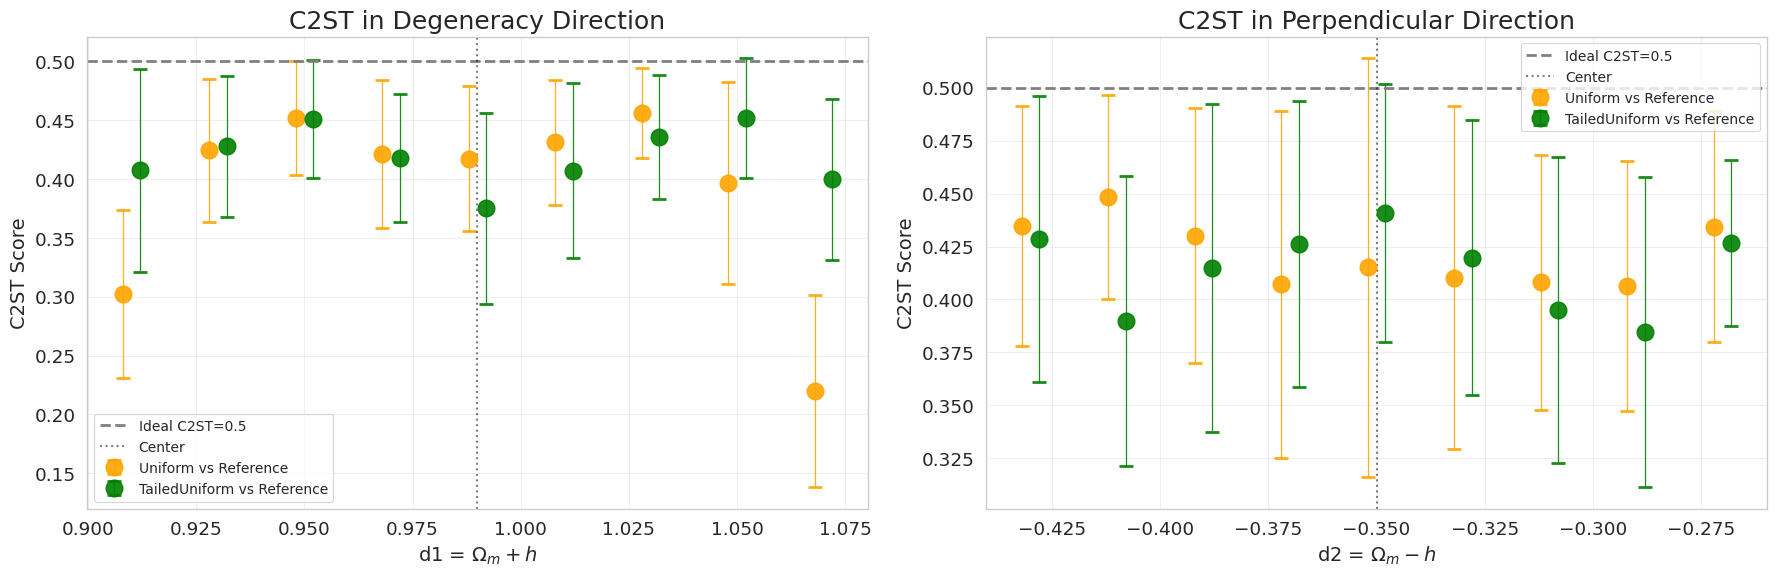


d1 = $\Omega_m + h$:
  Uniform vs Reference:
    Mean: 0.3910
    Std:  0.0741
    Min:  0.2198
    Max:  0.4559
  TailedUniform vs Reference:
    Mean: 0.4190
    Std:  0.0236
    Min:  0.3748
    Max:  0.4516

d2 = $\Omega_m - h$:
  Uniform vs Reference:
    Mean: 0.4216
    Std:  0.0146
    Min:  0.4063
    Max:  0.4482
  TailedUniform vs Reference:
    Mean: 0.4140
    Std:  0.0184
    Min:  0.3847
    Max:  0.4408


In [58]:
# Plot directional C2ST results with error bars
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

directions = ['d1', 'd2']
direction_labels = ['d1 = $\\Omega_m + h$', 'd2 = $\\Omega_m - h$']
title_labels = ['Degeneracy Direction', 'Perpendicular Direction']
colors_method = {'Reference_vs_Uniform_NPE': 'orange', 'Reference_vs_TailedUniform_NPE': 'green'}
labels_method = {'Reference_vs_Uniform_NPE': 'Uniform vs Reference', 'Reference_vs_TailedUniform_NPE': 'TailedUniform vs Reference'}

# Define horizontal offsets for each method
method_names = list(colors_method.keys())
n_methods = len(method_names)
offsets = {method_names[0]: -0.002, method_names[1]: 0.002}  # Small horizontal offset

for ax_idx, (direction, direction_label, title_label) in enumerate(zip(directions, direction_labels, title_labels)):
    ax = axes[ax_idx]
    
    # Get results for this direction
    dir_results = directional_results[direction]
    c2st_results = dir_results['c2st_results']
    
    # Plot each method with error bars (no connecting lines)
    for method_name, method_data in c2st_results.items():
        bin_centers = method_data['bin_centers']
        c2st_values = method_data['c2st_by_bin']
        c2st_std = method_data['c2st_std_by_bin']
        
        # Apply horizontal offset
        bin_centers_offset = np.array(bin_centers) + offsets[method_name]
        
        # Plot points with error bars (no line)
        ax.errorbar(bin_centers_offset, c2st_values, yerr=c2st_std,
                   fmt='o', linewidth=0, markersize=12,
                   color=colors_method[method_name],
                   label=labels_method[method_name],
                   capsize=5, capthick=2, elinewidth=0.9, alpha=0.9)
    
    # Add reference line at 0.5
    ax.axhline(0.5, color='gray', linestyle='--', linewidth=2, label='Ideal C2ST=0.5')
    
    # Add vertical line at center
    ax.axvline(dir_results['center'], color='black', linestyle=':', linewidth=1.5, 
              alpha=0.5, label='Center')
    
    # Labels and formatting
    ax.set_xlabel(direction_label, fontsize=14)
    ax.set_ylabel('C2ST Score', fontsize=14)
    ax.set_title(f'C2ST in {title_label}', fontsize=18)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=10, loc='best')

plt.tight_layout()

# Save the figure
save_path = 'sci-2-dim-figures/grid_c2st_directional.pdf'
plt.savefig(save_path, bbox_inches='tight', dpi=150)
print(f"\nSaved directional C2ST plot to: {save_path}")

plt.show()

# Print summary comparison

for direction, direction_label in zip(directions, direction_labels):
    print(f"\n{direction_label}:")
    dir_results = directional_results[direction]
    c2st_results = dir_results['c2st_results']
    
    for method_name, method_data in c2st_results.items():
        c2st_values = method_data['c2st_by_bin']
        c2st_clean = c2st_values[~np.isnan(c2st_values)]
        
        print(f"  {labels_method[method_name]}:")
        print(f"    Mean: {np.mean(c2st_clean):.4f}")
        print(f"    Std:  {np.std(c2st_clean):.4f}")
        print(f"    Min:  {np.min(c2st_clean):.4f}")
        print(f"    Max:  {np.max(c2st_clean):.4f}")